# Main EDA notebook

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None  

In [51]:
# Notes
# tables dealt with: 1, 2, 3, 4, 5, 6
#  7 by nr zbiornika TBD

In [52]:
zuzycie01_raw = pd.read_excel("data/01zuzycie.xlsx")
zbiorniki02_raw = pd.read_excel("data/02zbiorniki.xlsx")
liczniki03_raw = pd.read_excel("data/03liczniki.xlsx")
firmy04_raw = pd.read_excel("data/04firmy.xlsx")
osoby05_raw = pd.read_excel("data/05osoby.xlsx")
deklarowane06_raw = pd.read_excel("data/06deklarowane.xlsx")

In [53]:
# zmiana nazw kolumn
zuzycie01 = zuzycie01_raw.drop(['Lp.'], axis = 1)
c = zuzycie01.columns
zuzycie01 = zuzycie01.rename(columns = {c[0]: 'nr_licznika',
                                        c[1]: 'osoba',
                                        c[2]: 'adres_licznika',
                                        c[3]: 'zuzycie_wody',
                                        c[4]: 'srednie_zuzucie_wody'})
for i in range(5, len(c)):
    zuzycie01.rename(columns = {c[i]: str(i)})

                     
zbiorniki02 = zbiorniki02_raw.drop(['Lp.'], axis = 1)
c = zbiorniki02.columns
zbiorniki02 = zbiorniki02.rename(columns = {c[0]: 'nr_zbiornika',
                              c[1]: 'osoba',
                              c[2]: 'adres_licznika',
                              c[3]: 'adres_zamieszkania'})

liczniki03 = liczniki03_raw.drop(['Lp.'], axis = 1)
c = liczniki03.columns
liczniki03 = liczniki03.rename(columns = {c[0]: 'nr_licznika',
                                          c[1]: 'osoba',
                                          c[2]: 'adres_licznika',
                                          c[3]: 'adres_zamieszkania'})

firmy04 = firmy04_raw.drop(['Lp.'], axis = 1)
c = firmy04.columns
firmy04 = firmy04.rename(columns = {c[0]: 'nr_koncesji',
                              c[1]: 'nazwa_firmy',
                              c[2]: 'adres_firmy',
                              c[3]: 'nr_pojazdu',
                              c[4]: 'pojemnosc_pojazdu'})

osoby05 = osoby05_raw.drop(['Lp.'], axis = 1)
c = osoby05.columns
osoby05 = osoby05.rename(columns = {c[0]: 'nr_zbiornika',
                              c[1]: 'adres_licznika',
                              c[2]: 'liczba_osob_zameldowanych',
                              c[3]: 'liczba_osob_smieci'})

deklarowane06 = deklarowane06_raw.drop(['Lp.'], axis = 1)
c = deklarowane06.columns
deklarowane06 = deklarowane06.rename(columns = {c[0]: 'nr_zbiornika',
                                                c[1]: 'adres_licznika',
                                                c[2]: 'data_odbioru',
                                                c[3]: 'deklaracja_mieszkaniec',
                                                c[4]: 'deklaracja_firma',
                                                c[5]: 'pobrana_woda',
                                                c[6]: 'pobrana_woda_ogrodowa',
                                                c[7]: 'nr_pojazdu'})


In [54]:
# wyliczenie liczby osób jako średniej z zameldowanych i bazy śmieciowej
# i wyrzucenie tych kolumn
osoby05['liczba_osob'] = (osoby05['liczba_osob_zameldowanych'] + osoby05['liczba_osob_smieci'])/2
osoby05 = osoby05.drop(['liczba_osob_zameldowanych', 'liczba_osob_smieci'], axis = 1)

# czyszczenie deklarowanych
deklarowane06 = deklarowane06.drop(['pobrana_woda_ogrodowa'], axis = 1)

In [55]:
# Łączenie tabel i usuwanie niepotrzebnych kolumn

liczniki_zbiorniki = zbiorniki02.set_index(['adres_licznika', 'osoba', 'adres_zamieszkania'])\
                    .join(liczniki03.set_index(['adres_licznika', 'osoba', 'adres_zamieszkania']))\
                    .reset_index()

# drop kolumn adres zamieszkania skoro wszedzie jest taki sam jak adres licznika
liczniki_zbiorniki = liczniki_zbiorniki.drop('adres_zamieszkania', axis = 1)


liczniki_z_osobami = liczniki_zbiorniki.set_index(['adres_licznika', 'nr_zbiornika'])\
                    .join(osoby05.set_index(['adres_licznika', 'nr_zbiornika']))\
                    .reset_index()

licz_os_deklaracje = liczniki_z_osobami.set_index(['adres_licznika', 'nr_zbiornika'])\
                    .join(deklarowane06.set_index(['adres_licznika', 'nr_zbiornika']))\
                    .reset_index()

licz_os_dekl_pojaz = licz_os_deklaracje.set_index(['nr_pojazdu'])\
                    .join(firmy04.set_index(['nr_pojazdu']))\
                    .reset_index()

dane_koncowe = licz_os_dekl_pojaz.set_index(['nr_licznika', 'osoba', 'adres_licznika'])\
                    .join(zuzycie01.set_index(['nr_licznika', 'osoba', 'adres_licznika']))\
                    .reset_index()

In [56]:
licz_os_dekl_pojaz.columns

Index(['nr_pojazdu', 'adres_licznika', 'nr_zbiornika', 'osoba', 'nr_licznika',
       'liczba_osob', 'data_odbioru', 'deklaracja_mieszkaniec',
       'deklaracja_firma', 'pobrana_woda', 'nr_koncesji', 'nazwa_firmy',
       'adres_firmy', 'pojemnosc_pojazdu'],
      dtype='object')

In [57]:
# drop some usless columns
df = licz_os_dekl_pojaz.drop(['adres_licznika', 'osoba', 
                              'nr_licznika', 'nr_koncesji', 
                              'nazwa_firmy', 'adres_firmy',
                              'data_odbioru'], axis = 1)

In [58]:
df['pobrana_woda'] = dane_koncowe['srednie_zuzucie_wody']

In [59]:
df.head()

,nr_pojazdu,nr_zbiornika,liczba_osob,deklaracja_mieszkaniec,deklaracja_firma,pobrana_woda,pojemnosc_pojazdu
0,PGN 415KA,Z00045,3.5,4.0,4.0,10.428971,18.0
1,PGN 415KA,Z00089,5.5,15.0,14.0,20.712486,18.0
2,PGN 415KA,Z00165,4.0,9.0,9.0,10.142857,18.0
3,PGN 415KA,Z00367,3.0,10.0,9.0,9.078114,18.0
4,PGN 415KA,Z00465,5.0,10.0,9.0,15.371429,18.0


# Analiza bez miesięcznych pobrań i numerów zbiorników

In [60]:
# drop that is controversial - experimental
df_bez_zbiornikow = df.drop(['nr_zbiornika'], axis = 1)

In [61]:
df_bez_zbiornikow.head()

,nr_pojazdu,liczba_osob,deklaracja_mieszkaniec,deklaracja_firma,pobrana_woda,pojemnosc_pojazdu
0,PGN 415KA,3.5,4.0,4.0,10.428971,18.0
1,PGN 415KA,5.5,15.0,14.0,20.712486,18.0
2,PGN 415KA,4.0,9.0,9.0,10.142857,18.0
3,PGN 415KA,3.0,10.0,9.0,9.078114,18.0
4,PGN 415KA,5.0,10.0,9.0,15.371429,18.0


In [62]:
df_bez_zbiornikow['st_oddanej_do_pobranej'] = (df_bez_zbiornikow['deklaracja_mieszkaniec'] + 
                                                df_bez_zbiornikow['deklaracja_firma'])/2 / \
                                                df_bez_zbiornikow['pobrana_woda']

In [63]:
df_bez_zbiornikow['deficyt_litrow'] = df_bez_zbiornikow['pobrana_woda'] - \
                                    (df_bez_zbiornikow['deklaracja_mieszkaniec'] + \
                                    df_bez_zbiornikow['deklaracja_firma'])/2 
                                                

In [64]:
# get dummy variables for licz_os_dekl
df_bez_zbiornikow = pd.get_dummies(df_bez_zbiornikow)

In [65]:
df_bez_zbiornikow.head()

,liczba_osob,deklaracja_mieszkaniec,deklaracja_firma,pobrana_woda,pojemnosc_pojazdu,st_oddanej_do_pobranej,deficyt_litrow,nr_pojazdu_PGN 415KA,nr_pojazdu_PGN 457JE,nr_pojazdu_PGN132HJ,nr_pojazdu_PGN554HE,nr_pojazdu_PGN918CC,nr_pojazdu_PGN943GW
0,3.5,4.0,4.0,10.428971,18.0,0.383547,6.428971,1,0,0,0,0,0
1,5.5,15.0,14.0,20.712486,18.0,0.700061,6.212486,1,0,0,0,0,0
2,4.0,9.0,9.0,10.142857,18.0,0.887324,1.142857,1,0,0,0,0,0
3,3.0,10.0,9.0,9.078114,18.0,1.046473,-0.421886,1,0,0,0,0,0
4,5.0,10.0,9.0,15.371429,18.0,0.618030,5.871429,1,0,0,0,0,0


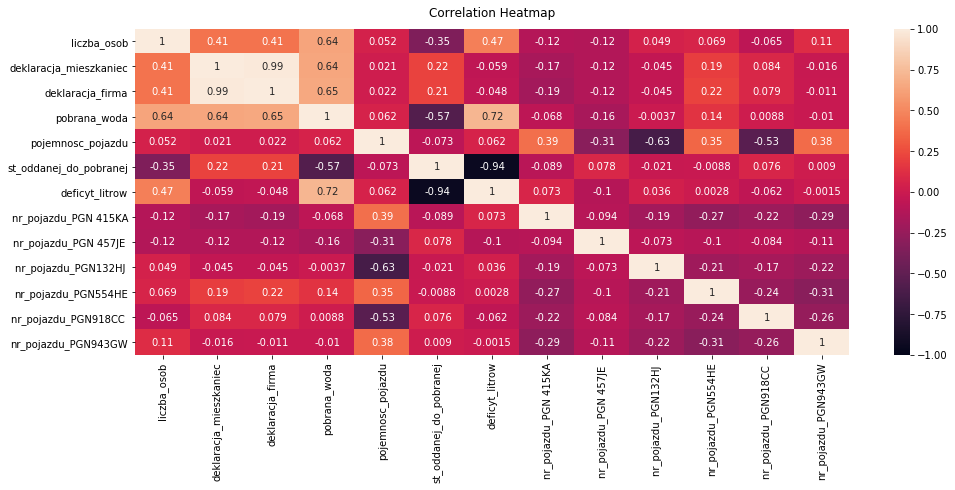

In [66]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(df_bez_zbiornikow.corr(), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

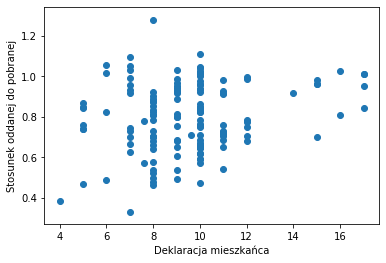

In [67]:
plt.scatter(df_bez_zbiornikow['deklaracja_mieszkaniec'], df_bez_zbiornikow['st_oddanej_do_pobranej'])
plt.xlabel("Deklaracja mieszkańca")
plt.ylabel("Stosunek oddanej do pobranej")
plt.show()

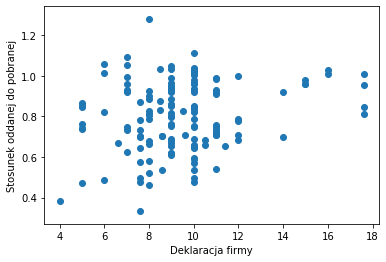

In [68]:
plt.scatter(df_bez_zbiornikow['deklaracja_firma'], df_bez_zbiornikow['st_oddanej_do_pobranej'])
plt.xlabel("Deklaracja firmy")
plt.ylabel("Stosunek oddanej do pobranej")
plt.show()

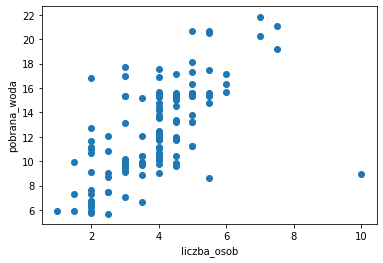

In [69]:
plt.scatter(df_bez_zbiornikow['liczba_osob'], df_bez_zbiornikow['pobrana_woda'])
plt.xlabel("liczba_osob")
plt.ylabel("pobrana_woda")
plt.show()

In [70]:
df_bez_zbiornikow = df_bez_zbiornikow.sort_values(by="deficyt_litrow", ascending = False)

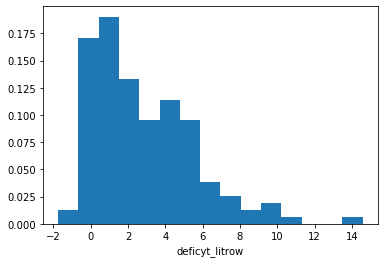

In [71]:
plt.hist(df_bez_zbiornikow["deficyt_litrow"], 15, density=True)
plt.xlabel('deficyt_litrow')
plt.show()

# Analiza ze zbiornikami

In [72]:
df.head()

,nr_pojazdu,nr_zbiornika,liczba_osob,deklaracja_mieszkaniec,deklaracja_firma,pobrana_woda,pojemnosc_pojazdu
0,PGN 415KA,Z00045,3.5,4.0,4.0,10.428971,18.0
1,PGN 415KA,Z00089,5.5,15.0,14.0,20.712486,18.0
2,PGN 415KA,Z00165,4.0,9.0,9.0,10.142857,18.0
3,PGN 415KA,Z00367,3.0,10.0,9.0,9.078114,18.0
4,PGN 415KA,Z00465,5.0,10.0,9.0,15.371429,18.0


In [73]:
df_new = df.copy()

df_new['st_oddanej_do_pobranej'] = (df['deklaracja_mieszkaniec'] + 
                                         df['deklaracja_firma'])/2 / \
                                         df['pobrana_woda']

In [74]:
df_new.head()

,nr_pojazdu,nr_zbiornika,liczba_osob,deklaracja_mieszkaniec,deklaracja_firma,pobrana_woda,pojemnosc_pojazdu,st_oddanej_do_pobranej
0,PGN 415KA,Z00045,3.5,4.0,4.0,10.428971,18.0,0.383547
1,PGN 415KA,Z00089,5.5,15.0,14.0,20.712486,18.0,0.700061
2,PGN 415KA,Z00165,4.0,9.0,9.0,10.142857,18.0,0.887324
3,PGN 415KA,Z00367,3.0,10.0,9.0,9.078114,18.0,1.046473
4,PGN 415KA,Z00465,5.0,10.0,9.0,15.371429,18.0,0.618030


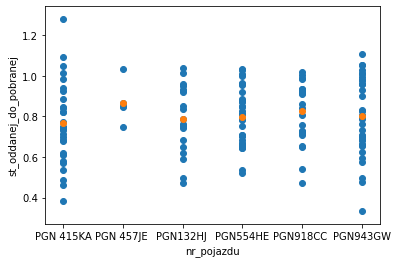

In [75]:
plt.scatter(df_new['nr_pojazdu'], df_new['st_oddanej_do_pobranej'])
#srednie
srednie = df_new.groupby("nr_pojazdu").mean()['st_oddanej_do_pobranej'].to_frame().reset_index()
plt.scatter(srednie['nr_pojazdu'], srednie['st_oddanej_do_pobranej'])

plt.xlabel("nr_pojazdu")
plt.ylabel("st_oddanej_do_pobranej")
plt.show()

In [76]:
srednie

,nr_pojazdu,st_oddanej_do_pobranej
0,PGN 415KA,0.768077
1,PGN 457JE,0.868382
2,PGN132HJ,0.788896
3,PGN554HE,0.795454
4,PGN918CC,0.827286
5,PGN943GW,0.800908
